# Project Feasibility Classifier
This notebook trains a model to classify project feasibility levels using an optimized machine learning pipeline.

In [1]:

import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

warnings.filterwarnings('ignore')


In [2]:

def financial_data_pipeline(data_path='data/Operational_Data_New.xlsx'):
    answer2id = {'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3}
    level2id = {'L1': 0, 'L2': 1, 'L3': 2, 'L4': 3}
    df = pd.read_excel(data_path, sheet_name='Sample data')
    df['level'] = df['level'].str.split('-').str[0].str.strip()
    df.replace(answer2id, inplace=True)
    df.replace(level2id, inplace=True)
    
    Y = df['level'].values
    X = df.drop(columns=['level']).values
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
    
    scaler = StandardScaler()
    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    
    sm = SMOTE(random_state=42)
    Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
    
    return Xtrain, Xtest, Ytrain, Ytest

Xtrain, Xtest, Ytrain, Ytest = financial_data_pipeline()


In [3]:

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, n_iter=10, cv=5, verbose=2, n_jobs=-1)
rf_grid.fit(Xtrain, Ytrain)
best_rf = rf_grid.best_estimator_

selector = SelectFromModel(best_rf)
selector.fit(Xtrain, Ytrain)
Xtrain = selector.transform(Xtrain)
Xtest = selector.transform(Xtest)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [4]:

cls = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, max_depth=20)),
        ('lgbm', LGBMClassifier(n_estimators=200, max_depth=10))
    ],
    final_estimator=LGBMClassifier(n_estimators=100, max_depth=5)
)

cls.fit(Xtrain, Ytrain)
Ptrain = cls.predict(Xtrain)
Ptest = cls.predict(Xtest)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 892, number of used features: 9
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

====================== Train CLS REPORT =======================
              precision    recall  f1-score   support

          L1       0.65      0.97      0.78       223
          L2       0.90      1.00      0.94       223
          L3       0.73      0.99      0.84       223
          L4       0.25      0.00      0.01       223

    accuracy                           0.74       892
   macro avg       0.63      0.74      0.64       892
weighted avg       0.63      0.74      0.64       892

====================== Test CLS REPORT =======================
              precision    recall  f1-score   support

          L1       0.17      0.14      0.16        49
          L2       0.24      0.29      0.26        45
          L3       0.19      0.18      0.18        50
          L4       0.23      0.23      0.23        56

    accuracy                           0.21       200
   macro avg       0.21      0.21      0.21       200
weighted avg       0.21      0.21      0.21       200



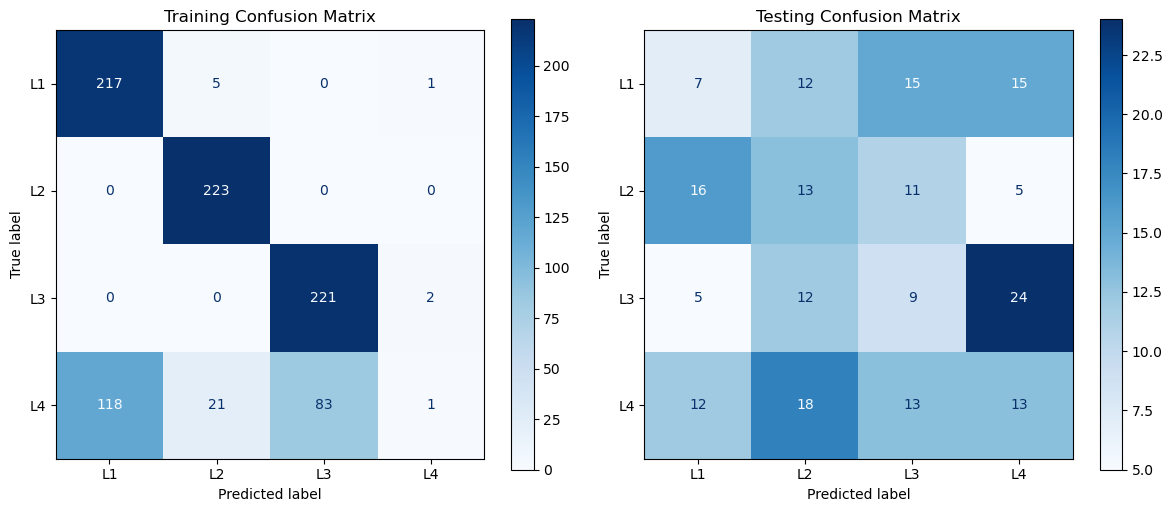

In [5]:

print("====================== Train CLS REPORT =======================")
print(classification_report(Ytrain, Ptrain, target_names=['L1', 'L2', 'L3', 'L4']))

print("====================== Test CLS REPORT =======================")
print(classification_report(Ytest, Ptest, target_names=['L1', 'L2', 'L3', 'L4']))

cm_train = confusion_matrix(Ytrain, Ptrain)
cm_test = confusion_matrix(Ytest, Ptest)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
disp_train = ConfusionMatrixDisplay(cm_train, display_labels=['L1', 'L2', 'L3', 'L4'])
disp_train.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Training Confusion Matrix")

disp_test = ConfusionMatrixDisplay(cm_test, display_labels=['L1', 'L2', 'L3', 'L4'])
disp_test.plot(ax=axes[1], cmap="Blues")
axes[1].set_title("Testing Confusion Matrix")
plt.tight_layout()
plt.show()


In [6]:

with open('artifacts/operational_cls.pkl', 'wb') as f:
    pickle.dump(cls, f)


In [7]:

def predict_level(sample_json):
    answer2id = {'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3}
    id2level = {0: 'L1', 1: 'L2', 2: 'L3', 3: 'L4'}
    sample_df = pd.DataFrame([sample_json]).replace(answer2id)
    sample_df = selector.transform(sample_df.values)
    response = cls.predict(sample_df)
    return id2level[int(response[0])]

sample_json = {f'Q{i+1}': 'A1' for i in range(20)}
predict_level(sample_json)


'L4'